# __Anomaly Map Generation__
Generates standardized anomaly map for reanalysis geopotential height and wind data, averaged every 3 months before large flooding events. 

## Data Wrangling

#### Import packages

In [1]:
#custom packages
import env_methods as em
import vis_methods as vm 

#standard packages
import pandas as pd 
import numpy as np 
import copy

#### File locations

In [2]:
monmean_dir = r'D:\NOAA Reanalysis Data\Atmo Monthly Means'
riv_path = r'D:\Data\river data\USGS\top_ten.csv' 

#### Acquire data - print river dates

In [3]:
riv_dates = pd.read_csv(riv_path)
data_package = em.get_data(monmean_dir, True, [1, 2000, 1, 2012])

acquring data from hgt.mon.mean.nc
acquring data from uwnd.mon.mean.nc
acquring data from vwnd.mon.mean.nc


#### Standardize pressure values to generate anomaly maps 
Z-score calculated for each lat/lon point by 
\begin{align}
Z = \frac{x - \bar{x}_{monthly}}{\sigma_{monthly}}
\end{align}

In [4]:
s_data_package = copy.deepcopy(data_package) #deep copy required due to nested elements 

for p in s_data_package['level']:
    p = s_data_package['level'].index(p)
    var = s_data_package['nc_vars']['hgt'][:, p, :, :]
    var = em.normalize_data(var, s_data_package['time'])
    s_data_package['nc_vars']['hgt'][:, p, :, :] = var

#### Find dates of interest
1. indices of USGS flood event in NCEP-NCAR indices
2. any USGS flood event outside of the NCEP-NCAR data availability is NaN

In [5]:
riv_dates

,hermann,louisville,vicksburg
0,7/31/1993,1/26/1937,5/17/2011
1,6/7/1903,3/7/1945,5/1/1927
2,7/19/1951,2/16/1884,2/17/1937
3,5/19/1995,3/12/1964,5/12/1973
4,4/28/1944,4/2/1913,4/8/1945
5,5/21/1943,2/16/1883,2/23/1950
6,10/5/1986,3/6/1997,4/13/1975
7,5/4/2017,1/22/1907,4/20/2008
8,4/25/1973,3/16/2015,5/27/1983
9,6/29/1947,3/23/1933,4/15/1897


In [6]:
riv_time_ind = pd.DataFrame()
for loc in riv_dates.columns.tolist():
    riv_dates[loc] = pd.to_datetime(riv_dates[loc], format = "%m/%d/%Y") #convert to dt object
    loc_ind = []
    danger = [0, len(data_package['time'])] #signal of out of bounds value
    
    for event in riv_dates[loc]:
        ind = em.find_closest_val(event, s_data_package['time'])
        
        if ind in danger:
            ind = np.nan
        loc_ind.append(ind)
        
    riv_time_ind[loc] = loc_ind

In [7]:
riv_time_ind

,hermann,louisville,vicksburg
0,1711,1033,1925
1,629,1130,916
2,1207,398,1034
3,1733,1358,1468
4,1120,747,1131
5,1109,386,1190
6,1629,1754,1491
7,1967,673,1888
8,1468,1967,1589
9,1158,987,555


#### Collect reanalysis data for each location three months before each flood event, concatenate, and average
 - Generate a map of standard anomaly for all data 3 months before flood event for each location 
 - Do this for both the standardized and non-standardized datasets
 - Also generate a "mean" map of all data for each data point 

In [8]:
flood = dict() #averaged data 
s_flood = dict() #averaged standardized data 
num_months = 3

for loc in riv_time_ind.columns.tolist(): #iterate through location
    indices = []
    for ind in riv_time_ind[loc]: #iterate through all indices at location 
        if not np.isnan(ind):
            ind = int(ind)
            for i in np.arange(0, num_months): #append index and two month prior indices
                indices.append(ind - i)
                
    temp_dict = dict() #non standardized data 
    s_temp_dict = dict() #standardized data 
    
    for var in data_package['nc_vars']:
        temp_dict[var] = np.mean(data_package['nc_vars'][var][indices, :, :, :] , axis = 0) #cut down to indices, then average 
        s_temp_dict[var] = np.mean(s_data_package['nc_vars'][var][indices, :, :, :] , axis = 0)
    flood[loc] = temp_dict
    s_flood[loc] = s_temp_dict

In [9]:
mean_data = dict()
s_mean_data = dict()
for var in data_package['nc_vars']:
    mean_data[var] = np.nanmean(data_package['nc_vars'][var][:, :, :, :] , axis = 0)
    s_mean_data[var] = np.nanmean(s_data_package['nc_vars'][var][:, :, :, :] , axis = 0)

## Visualization

#### Height Anomaly Plots
- Colormap refers to number of stdevs from mean behavior at that lat/lon position 
- Bounding box controlled by values below
- pressure level can be 1000, 850, 500

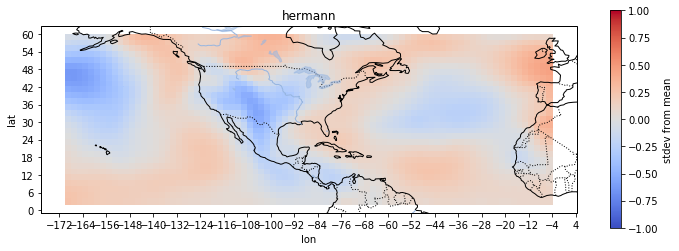

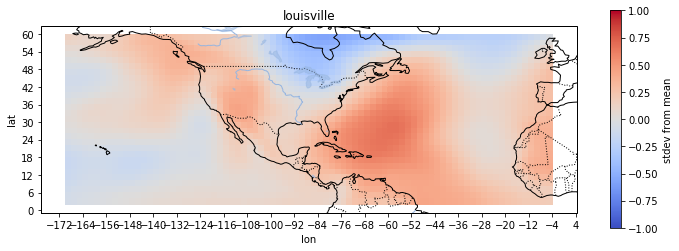

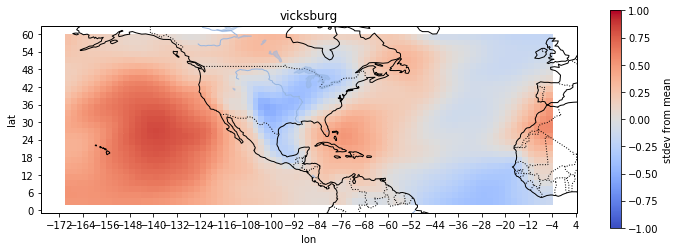

In [10]:
lat_start = 60
lat_end = 0
lon_start = 360 - 170
lon_end = 360 - 0

p = 1000
for loc in flood.keys():
    vm.height_anomaly_plot(lat_start, lat_end, lon_start, lon_end, data_package['lat'], data_package['lon'], data_package['level'], p, s_flood[loc], loc)

#### Non-Standardized Behavior Plots with Wind Speed Vectors
- Colormapped GPH (non-standardized) with wind vectors plotted on top
- First three plots show behavior averaged three months before each flood event
- Lowest plot shows all data, averaged

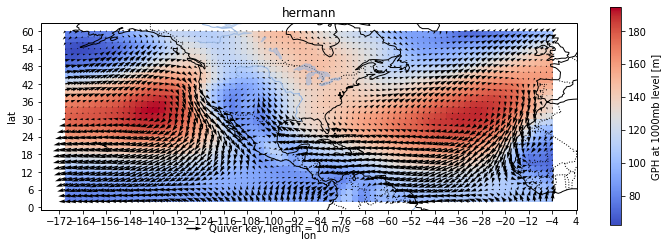

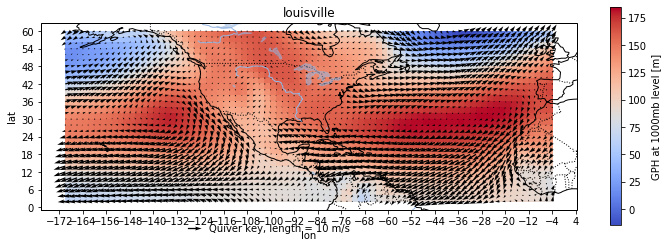

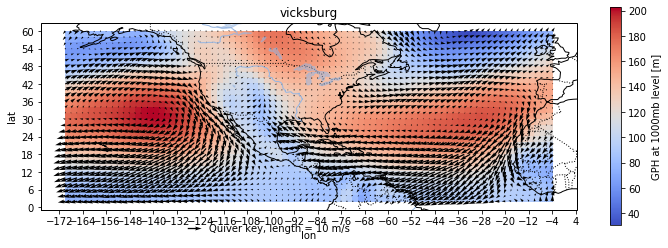

In [11]:
for loc in flood.keys():
    vm.average_plot(lat_start, lat_end, lon_start, lon_end, data_package['lat'], data_package['lon'], data_package['level'], p, flood[loc], loc)

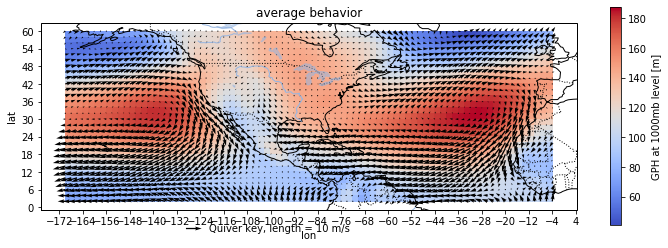

In [12]:
vm.average_plot(lat_start, lat_end, lon_start, lon_end, data_package['lat'], data_package['lon'], data_package['level'], p, mean_data, 'average behavior')

# 

In [13]:
print('time start: ' +str(data_package['time'][0]))
print('time end: ' +str(data_package['time'][-1]))

time start: 1851-01-01 00:00:00
time end: 2014-12-01 00:00:00
